# A XIII Legislatura: o princípio

```{epigraph}
Da Rosa, nada digamos por agora.

-- Sampaio Bruno, «Os Cavaleiros do Amor»
```

## As eleições legislativas de 2015


```{margin} Resultados eleitorias das legislativas de 2015
![fishy](./_images/res_2015.png) 
Fonte: CNE {cite:p}`cneLegislativas2015Resultados2015`
```

A XIII Legislatura resultou das eleições legislativas de 2015. Os resultados colocam a coligação «Portugal à Frente» (PSD e CDS-PP) à frente com 39% dos votos. O processo de formação do governo iria, contudo, introduzir uma novidade no histórico político nacional: a formação de Governo pela segunda força mais votada (PS) suportado para tal por uma maioria de Esquerda (BE, PCP e PEV).

## Os dados das votações

In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from datetime import timedelta
#sns.set(font="EB Garamond")
sns.set_theme(style="whitegrid", palette="pastel")
from myst_nb import glue
%matplotlib inline

In [2]:
## Get the data
from urllib.request import urlopen
import xml.etree.ElementTree as ET

#l13_ini_url = 'https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a686379395953556c4a4a5449775447566e61584e7359585231636d45765357357059326c6864476c3259584e5953556c4a4c6e687462413d3d&fich=IniciativasXIII.xml&Inline=true'
#l13_ini_tree = ET.parse(urlopen(l13_ini_url))
l13_ini_file = './l13_ini.xml'
l13_ini_tree = ET.parse(l13_ini_file)
l14_ini_file = './l14_ini.xml'
l14_ini_tree = ET.parse(l14_ini_file)


In [3]:
from bs4 import BeautifulSoup
import re
import pandas as pd

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [4]:
import collections

def ini_to_df(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for voting in root.findall(".//pt_gov_ar_objectos_VotacaoOut"):
        votep = voting.find('./detalhe')
        if votep is not None:
            init_dict = collections.OrderedDict()
            counter +=1                 
            init_dict['id'] = voting.find('id').text
            ## Add the "I" for Type to mark this as coming from "Iniciativas"
            init_dict['Tipo'] = "I"
            for c in voting:
                if c.tag == "detalhe":
                    for party, vote in parse_voting(c.text).items():
                        init_dict[party] = vote 
                elif c.tag == "descricao":
                        init_dict[c.tag] = c.text
                elif c.tag == "ausencias":
                        init_dict[c.tag] = c.find("string").text
                else:
                        init_dict[c.tag] = c.text
            init_list.append(init_dict)
        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [5]:
def ini_to_df_ini(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for ini in root.findall("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
        init_dict = collections.OrderedDict()
        counter +=1
        for c in ini:
            if c.tag == "iniAutorGruposParlamentares":
                if c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP') is not None:
                    init_dict[c.tag] = c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP').text
            else:
                init_dict[c.tag] = c.text
        init_list.append(init_dict)

        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [6]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show
from scipy.cluster.hierarchy import dendrogram

def political_distance_matrix(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')

    ## Create a square dataframe with the pairwise distances: the distance matrix
    distmat = pd.DataFrame(
        squareform(pwdist), # pass a symmetric distance matrix
        columns = vdf_votes_t.index,
        index = vdf_votes_t.index
    )
    return distmat
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

def political_pwdist(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')
    return pwdist
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
    
def political_distance_clustermap(vdf, plist, subtitle):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Perform hierarchical linkage on the distance matrix using Ward's method.
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )
    sns.clustermap(
        distmat,
        annot = True,
        cmap=sns.color_palette("Reds_r"),
        linewidth=1,
        #standard_scale=1,
        row_linkage=distmat_link,
        col_linkage=distmat_link,
        #fmt=".0%",
        figsize=(7,7)).fig.suptitle(subtitle)
    plt.show()

def political_linkage(vdf,plist):
    vdf = vdf[plist]
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True)
    return distmat_link

def political_dendogram(vdf, plist, subtitle):
    vdf = vdf[plist]

    fig = plt.figure(figsize=(8,5))
    dendrogram(political_linkage(vdf,plist), labels=vdf.columns)
    plt.title(subtitle)
    plt.show()
    
def political_heatmap(vdf,plist,title):
    vdf_hmn = vdf[plist].replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)
    voting_palette = ["#FB6962","#FCFC99","#79DE79"]
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(vdf_hmn,
                square=False,
                yticklabels = False,
                cbar=False,
                cmap=sns.color_palette(voting_palette),
               )
    plt.title(title)
    plt.show()

In [7]:
l13_ini_df = ini_to_df(l13_ini_tree)
l14_ini_df = ini_to_df(l14_ini_tree)

In [8]:
l13_parties = ['BE', 'PCP' ,'PEV', 'PS', 'PAN', 'PSD','CDS-PP']
l14_parties = ['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PAN/CR','PSD','IL','CDS-PP', 'CH']

## Copy Livre voting record to new aggregate columns...
l14_ini_df["L/JKM"] = l14_ini_df["L"]
## ... and fill the NAs with JKM voting record.
l14_ini_df["L/JKM"] = l14_ini_df["L/JKM"].fillna(l14_ini_df["Joacine Katar Moreira (Ninsc)"])
l14_ini_df[["descricao","L","Joacine Katar Moreira (Ninsc)","L/JKM"]]
## Copy PAN voting record to new aggregate columns...
l14_ini_df["PAN/CR"] = l14_ini_df["PAN"]
## ... and update/replace with CR voting where it exists
l14_ini_df["PAN/CR"].update(l14_ini_df["Cristina Rodrigues (Ninsc)"])
l14_ini_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]]
votes = l13_ini_df


l14_votes = l14_ini_df
l14_votes['data']= pd.to_datetime(l14_votes['data'])
l14_votes['ano'] = pd.DatetimeIndex(l14_votes['data']).year
l14_votes['leg'] = 14
l14_votes_hm=l14_votes[l14_parties]
l14_votes_nu = l14_votes[l14_votes["unanime"] != "unanime"]
l14_votes_nu_hm=l14_votes_nu[l14_parties]
l14_min_date=min(l14_votes["data"])

votes['data']= pd.to_datetime(votes['data'])
votes['ano'] = pd.DatetimeIndex(votes['data']).year
votes['leg'] = 13
min_date=min(votes["data"])
max_date=l14_min_date - timedelta(1)

parties = l13_parties
votes = votes[(votes['data'] <= max_date)]
votes_hm=votes[l13_parties]
votes_nu = votes[votes["unanime"] != "unanime"]
votes_nu_hm=votes_nu[l13_parties]

```{margin} Estatísticas base
Os dados essenciais do ficheiro XML importado são as seguintes:
```


In [25]:
from datetime import datetime
from IPython.display import display, Markdown, Latex

display(Markdown("*Total de votações:* {}".format(votes.shape[0])))
display(Markdown("*Data limite inferior:* {}".format(datetime.date(min_date))))
display(Markdown("*Data limite superior:* {}".format(datetime.date(max_date))))



*Total de votações:* 6393

*Data limite inferior:* 2015-10-23

Para a XIII legislatura os dados analisados dizem exclusivamente respeito às Iniciativas parlamentares (as Actividades, em menor número e que dizem respeito a temas como votos de pesar ou condenação, não estão presentes na página do Parlamento de Dados Abertos).

O processamento inicial resulta num conjunto bastante alargado de colunas e observações (votações, uma por linha), nomeadamente os votos dos vários partidos:

In [46]:
with pd.option_context("display.max_columns", 0):
    display(votes[["resultado"] + parties])

resultado         BE        PCP  ...      PAN        PSD     CDS-PP
0     Aprovado    A Favor    A Favor  ...  A Favor  Abstenção    A Favor
1     Aprovado    A Favor    A Favor  ...      NaN    A Favor    A Favor
2     Aprovado    A Favor    A Favor  ...  A Favor  Abstenção    A Favor
3     Aprovado    A Favor    A Favor  ...      NaN    A Favor    A Favor
4     Aprovado    A Favor    A Favor  ...  A Favor  Abstenção  Abstenção
...        ...        ...        ...  ...      ...        ...        ...
6395  Aprovado  Abstenção  Abstenção  ...  A Favor    A Favor    A Favor
6396  Aprovado  Abstenção  Abstenção  ...  A Favor    A Favor    A Favor
6397  Aprovado    A Favor    A Favor  ...  A Favor    A Favor    A Favor
6398  Aprovado    A Favor    A Favor  ...  A Favor    A Favor    A Favor
6399  Aprovado    A Favor    A Favor  ...  A Favor    A Favor    A Favor

[6393 rows x 8 columns]

## Mapa térmico das votações

O mapa térmico de votações para a legislatura -- recordemos que nos permite ver através de cores todas as votações, dando uma imagem geral do comportamento dos vários partidos -- é o seguinte:

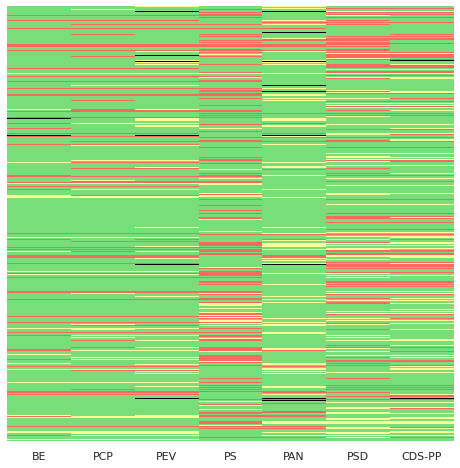

In [47]:
votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,-2]).fillna(0)

##RYG
voting_palette = ["black","#FB6962","#FCFC99","#79DE79",]

fig = plt.figure(figsize=(8,8))
sns.heatmap(votes_hmn ,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
            linewidths=0,
           )
plt.show()

## Votações idênticas

Das votações da legislatura é esta a matriz de votações idênticas:

In [48]:
pv_list = []
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'font-weight: bold;')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_hmn:
        pv_dict[column]=votes_hmn[votes_hmn[party] == votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

pv = pd.DataFrame(pv_list,index=votes_hm.columns)
pv.style.apply(highlight_diag, axis=None)

```{margin} Votos idênticos vs. distância de votos
Este quadro parece ser um dos mais populares, talvez por ser muito directo na mensagem que transmite. Por isso mesmo fica a nota: a consideração apenas dos votos "idênticos" desconsidera completamente a diferença entre votar Contra e Abstenção. Esta dimensão irá ser capturada na matriz de distâncias.
```

A visualização desta matriz através de um mapa térmico:

```{margin} Votos unânimes
Removendo os votos unânimes pode-se obter um mapa térmico semelhante, mas com uma escala diferente. Não há alteração substantiva ao anterior, nem a remoção dos votos unânimes altera as distâncias.

```

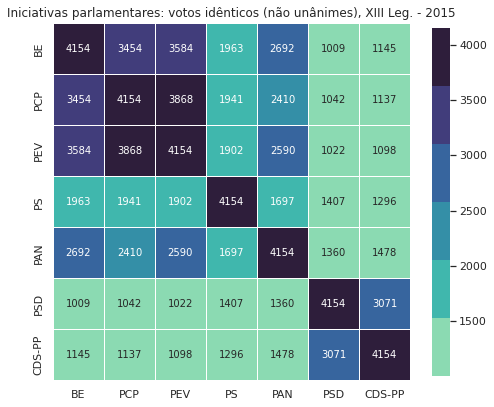

In [49]:
pv_nu_list = []
votes_nu_hmn = votes_nu_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,-2]).fillna(0)

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_nu_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_nu_hmn:
        pv_dict[column]=votes_nu_hmn[votes_nu_hmn[party] == votes_nu_hmn[column]].shape[0]
    pv_nu_list.append(pv_dict)

pv_nu = pd.DataFrame(pv_nu_list,index=votes_nu_hm.columns)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv_nu,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Iniciativas parlamentares: votos idênticos (não unânimes), XIII Leg.')

plt.show()

```{margin}
A tabela respectiva (observe-se o menor número de votações consideradas, dada a remoção das unânimes)
```

In [50]:
pv_nu.style.apply(highlight_diag, axis=None)

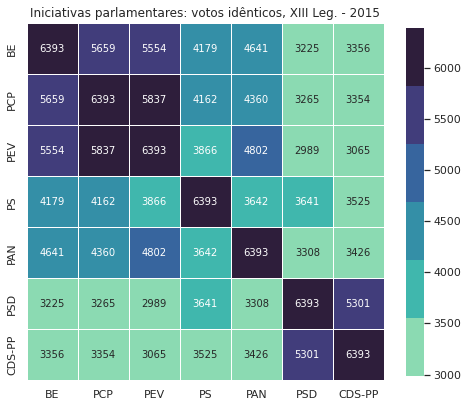

In [51]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Iniciativas parlamentares: votos idênticos, XIII Leg.')

plt.show()

## Matriz de distância e dendograma

Considerando a distância entre os votos (onde um voto a favor está mais perto de uma abstenção do que de um voto contra) obtemos o seguinte `clustermap` que conjuga a visualização da matriz de distância com o dendograma.

In [52]:
## Change the mapping, we now consider Abst and Aus the same
votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
distmat.style.apply(highlight_diag, axis=None)

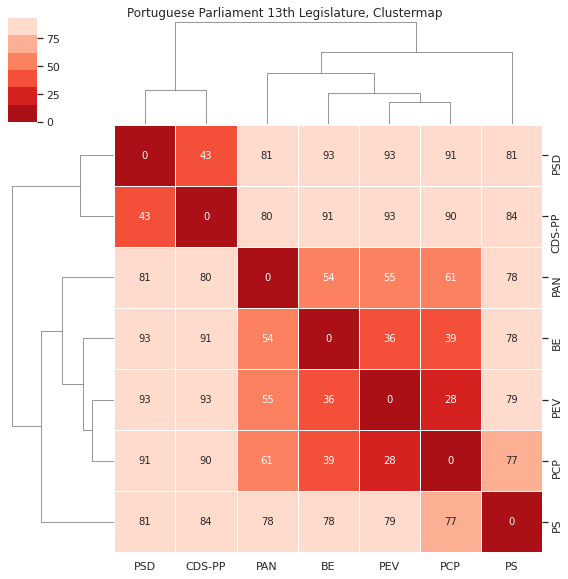

In [53]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 13th Legislature, Clustermap',y=1)
plt.show()

```{margin}
O dendograma respectivo é este, e como se vê é exactamente o mesmo que o apresentado no _clustermap_
```

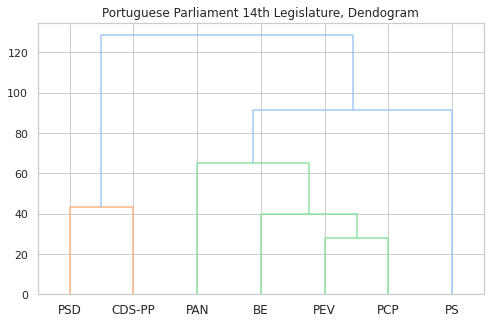

In [17]:
from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize=(8,5))
dendrogram(distmat_link, labels=votes_hmn.columns)

plt.title("Portuguese Parliament 14th Legislature, Dendogram")
plt.show()

Parece clara a identificação de dois grande blocos: PSD e CDS-PP, e todos os outros - e dentro destes, o PS e o PAN mais próximos entre si, e PCP, PEV e BE próximos entre eles.

## _Clustering_ de observações: DBSCAN e _Spectrum Scaling_

Uma forma diferente de determinar agrupamentos é através de métodos de _clustering_, que procuram determinar agrupamentos de pontos com base em mecanismos específicos de cada um dos algoritmos.

Vamos demonstrar dois deles, e como passo preliminar vamos transformar a nossa matriz de distâncias: ao contrário do dendograma anterior estes métodos utilizam uma matriz de afinidade, onde valores mais altos significam uma maior semelhança (e, consequentemente, para uma matriz simétrica a diagonal passa de 0 para 1).

Como passo preliminar normalizamos as distâncias no intervalo [0,1], após o qual obtemos a matriz de afinidade a partir da matriz de distância:

In [18]:
distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)
affinmat_mm.style.apply(highlight_diag, axis=None)

```{margin}
A matriz de afinidade normalizada pode ser vizualizada de forma semelhante à de distância; como está normalizada e numa escala $ 0 - 1 $ podem-se considerar os valores uma percentagem de afinidade. É importante considerar que, dado o processo de normalização, os valores apresentados ampliam as diferenças.
```

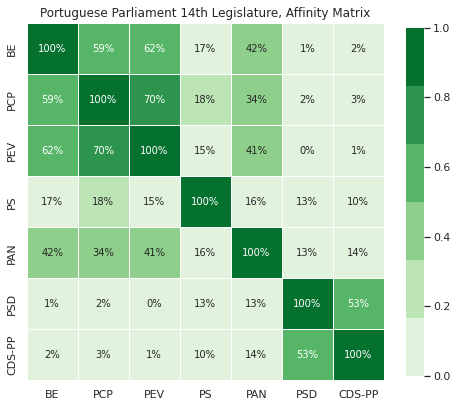

In [19]:
## Make the top triangle
mask = np.triu(np.ones_like(affinmat_mm, dtype=bool))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.title('Portuguese Parliament 14th Legislature, Affinity Matrix')

## Display the heatmap of the affinity matrix, masking the top triangle

sns.heatmap(
    affinmat_mm,
    cmap=sns.color_palette("Greens"),
    linewidth=1,
    fmt=".0%",
    annot = True,
    square =True,
    cbar_kws={"shrink": .8},
    #mask=mask,linewidths=.5
)

plt.show()

### DBSCAN

O DBSCAN é algoritmo que, entre outras características, não necessita de ser inicializado com um número pré-determinado de grupos, procedendo à sua identificação através da densidade dos pontos {cite}`DBSCANMacroscopicInvestigation2018`: o DBSCAN identifica os grupos de forma automática.


In [20]:
from sklearn.cluster import DBSCAN
dbscan_labels = DBSCAN(eps=1.3).fit(affinmat_mm)
dbscan_labels.labels_
dbscan_dict = dict(zip(distmat_mm,dbscan_labels.labels_))
pd.DataFrame.from_dict(dbscan_dict, orient='index', columns=["Group"]).T

BE  PCP  PEV  PS  PAN  PSD  CDS-PP
Group   0    0    0   0    0   -1      -1

Com DBSCAN identificamos 2 grupos: PSD e CDS-PP, e todos os restantes.

### Spectral clustering

Outra abordagem para efectuar a identificação de grupos  passa pela utilização de _Spectral Clustering_, uma forma de _clustering_ que utiliza os valores-próprios e vectores-próprios de matrizes como forma de determinação dos grupos. Este método necessita que seja determinado _a priori_ o número de _clusters_; assim, podemos usar este método para agrupamentos mais finos, neste caso identificando 3 grupos:

In [21]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

pd.DataFrame.from_dict(sc_dict, orient='index', columns=["Group"]).T

BE  PCP  PEV  PS  PAN  PSD  CDS-PP
Group   0    0    0   2    0    1       1

Neste caso, e por determinarmos que devem existir 3 grupos, ao grupo anteriormente identificado por DBSCAN (PSD e CDS-PP) junta-se uma divisão entre PS (isolado) e os restantes. Esta divisão é compatível com os valores que observamos anteriormente.

```{margin}
Ao MDS pode ser acrescentada informação dos grupos previamente identificados: nestes diagramas usamos as cores para denotar os grupos, tanto para DBSCAN como para Spectral Clustering.
```

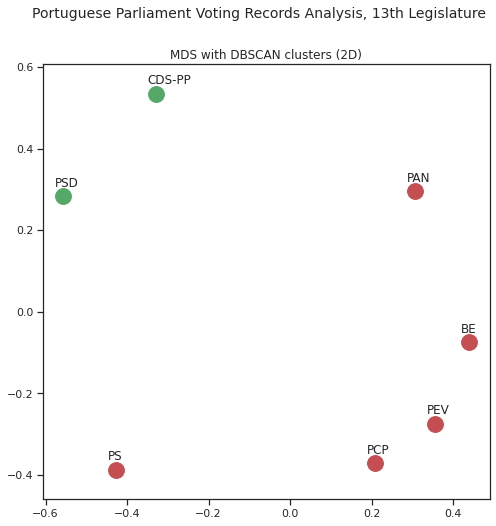

In [22]:
from sklearn.manifold import MDS
import random

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_
sns.set()
sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(8,8))

fig.suptitle('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)
ax.set_title('MDS with DBSCAN clusters (2D)')

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(dbscan_dict[label]+3), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

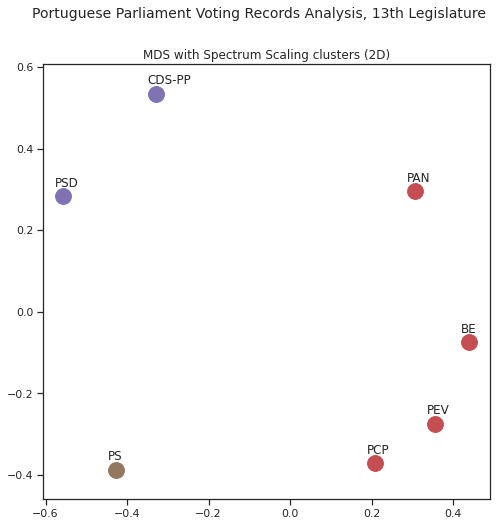

In [24]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]+3
                                ), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()
glue("mds_13", fig, display=False)

### _Multidimensional scaling_ 

Não temos ainda uma forma de visualizar a distância relativa de cada partido em relação aos outros com base nas distâncias/semelhanças: temos algo próximo com base no dendograma mas existem outras formas de visualização interessantes.

Uma das formas é o _multidimensional scaling_ que permite visualizar a distância ao projectar em 2 ou 3 dimensões (também conhecidas como _dimensões visualizavies_) conjuntos multidimensionais, mantendo a distância relativa {cite}`GraphicalRepresentationProximity`.

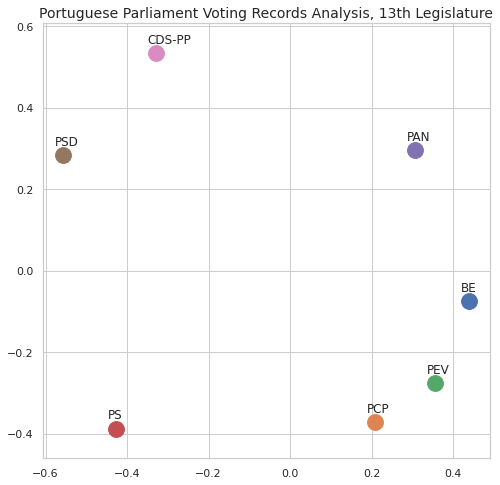

In [23]:
from sklearn.manifold import MDS


## Graphic options
sns.set()
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8,8))

plt.title('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))
plt.show()

Por último, o mesmo MDS em 3D, e em forma interactiva:

In [25]:
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 1000,
    height = 1000,
    title = "13th Legislature: 3D MDS",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
plot(fig, filename = 'l13-3d-mds.html')
display(HTML('l13-3d-mds.html'))

/tmp/ipykernel_49762/2725654250.py:15: MatplotlibDeprecationWarning:


The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.



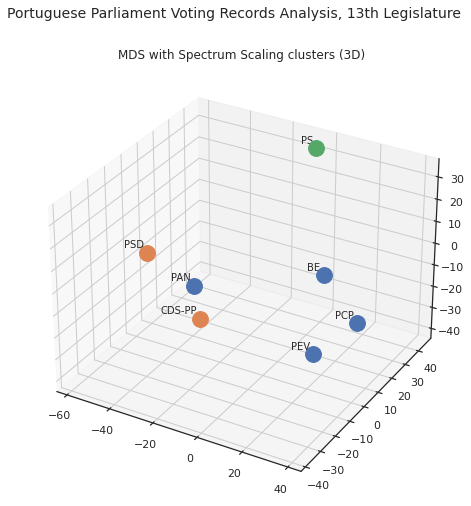

In [26]:
## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

from sklearn.manifold import MDS
import mpl_toolkits.mplot3d
import random

mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('Portuguese Parliament Voting Records Analysis, 13th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    #print(label,pmds_colors[label])
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()
